# FIXATION ANALYSES

To run this notebook, you need the pre-calculated fixation statistics in `/data/eye_tracking/02_gaze/fixations_all.csv`. 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from vr2f.eyetracking import et_plot_gaze_saccades
from vr2f.eyetracking.et_viz_utils import plot_image, get_saliency_map
from vr2f.utils.stats import run_rmanova_and_posthoc
from vr2f.staticinfo import PATHS, COLORS, CONSTANTS, TIMINGS

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
paths = PATHS()
colors = COLORS()
constants = CONSTANTS()
cm = constants.CM
timings = TIMINGS()
palette = colors.COLDICT

# 1. Load gaze and fixtion data

In [7]:
fpath = paths.DATA_ET / "02_gaze"
saccades = pd.read_csv(Path(fpath, "saccades_all.csv"))
fixations = pd.read_csv(Path(fpath, "fixations_all.csv"))
df_gaze = pd.read_csv(Path(fpath, "gaze_all.csv"))

In [8]:

# A DF with the design matrix:
design_df = (df_gaze
              .loc[:, ["sub_id", "trial_num", "emotion", "viewcond", "avatar_id"]]
              .drop_duplicates()
)

cond_dict = {
    "viewcond": {1: "mono", 2: "stereo"},
    "emotion": {1: "neutral", 2: "happy", 3: "angry", 4: "surprised"},
    "avatar_id": {1: "Woman_01", 2: "Woman_04", 3: "Woman_08"},
}

# timing parameters:
tw_p1_start, tw_p1_end = timings.ERP_WINDOWS["P1"]
tw_n170_start, tw_n170_end = timings.ERP_WINDOWS["N170"]
tw_epn_start, tw_epn_end = timings.ERP_WINDOWS["EPN"]
tw_lpc_start, tw_lpc_end = timings.ERP_WINDOWS["LPC"]

# 2. Visualize gaze traces and saccades

You can plot these supplementary figures to visualize the gaze and the detected saccades for specific trials like this:

In [9]:
# read in the preprocessed data
pattern = "withoutblinks-preproc.csv"

sub_list_str_et = [f for f in os.listdir(paths.DATA_ET_PREPROC) if pattern in f]
sub_list_str_et = [f.split("-")[0] for f in sub_list_str_et]
sub_list_str_et = np.unique(sorted(sub_list_str_et))

data_preproc = []
for sub_id in sorted(sub_list_str_et):
    fname = Path(paths.DATA_ET_PREPROC, f"{sub_id}-ET-{pattern}")
    df_clean = pd.read_csv(fname, sep=",")
    df_clean["sub_id"] = sub_id
    data_preproc.append(df_clean)

df_all = pd.concat(data_preproc, ignore_index=True)

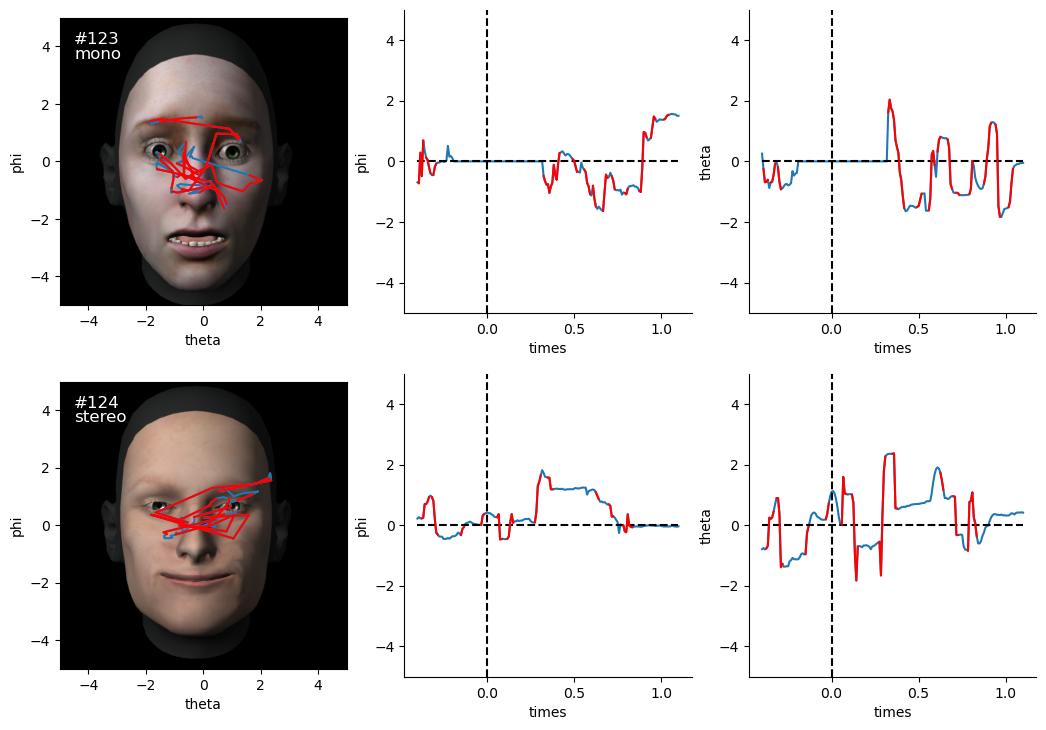

In [10]:
sub_id = "VR2FEM_S05"
trial_range = range(123, 125)

save_fig = False
myfig = et_plot_gaze_saccades.plot_gaze_sacc_per_trial(df_all, sub_id, trial_range, sfreq=120, min_sac_amp=0)

To render the PDFs in `results/figures/ET/Gaze_saccades` with all trials for a given subject (or all of them), use the 
bash functionality of `et_plot_gaze_saccades.py` (ideally with the slurm script in `/code/HPC`).  

# 3. Sanity checks

First, we plot the average gaze (per participant and trial) to make sure that we did not do something horrible when 
subtracting these values in the fashion of "baselining" to correct for drift in the tracking (e.g. due to slippage).

<Axes: xlabel='Horizontal [dva]', ylabel='Vertical [dva]'>

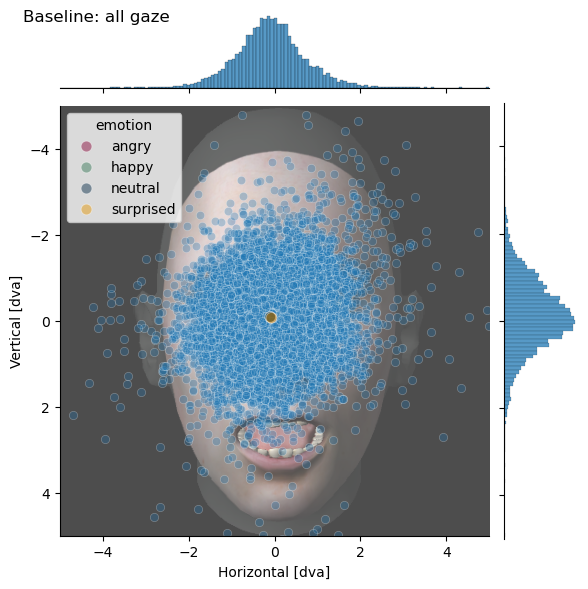

In [14]:
# A DF with the "baseline" for pitch and yaw (which we subtracted earlier):
baseline_df = (df_gaze
                .groupby(["sub_id", "trial_num"], as_index=False)
                .first()
                .loc[:, ["sub_id", "trial_num", "theta_baseline", "phi_baseline", "emotion"]]
)

# Baseline diagnostics:
fpath = Path(paths.FIGURES, "ET", "fixations", "diagnostics")

g = sns.jointplot(data=baseline_df, x="theta_baseline", y="phi_baseline", palette=palette,
                  alpha=0.3)
g.fig.axes[0].set_ylim(-5, 5)
g.fig.axes[0].set_xlim(-5, 5)
g.fig.axes[0].set_xlabel("Horizontal [dva]")
g.fig.axes[0].set_ylabel("Vertical [dva]")
g.fig.suptitle("Baseline: all gaze", x=0.05, ha="left")
g.fig.axes[0].invert_yaxis()

plot_faces.plot_image(av_name = "Woman_08", emotion = "angry", ax=g.fig.axes[0], invert=True, alpha=0.7)

baseline_df_sum = (baseline_df
                      .groupby(["emotion"], as_index=False)
                      .agg({"theta_baseline": "mean", "phi_baseline": "mean"})
                  )
sns.scatterplot(data=baseline_df_sum, x="theta_baseline", y="phi_baseline", hue="emotion",
                  palette=palette, ax=g.fig.axes[0], s=60, alpha=0.45)




Looks pretty ok! There is some variance also during the baseline, but almost all of it takes palce within +/- 2 dva from
the fixation cross. and everything (importantly also the condition averages) is neatly centered.   

Next, let's sort the fixations into three categories (as inspired by [Spiering & Dimigen, 2023](https://olaf.dimigen.de/papers/Spiering.Dimigen.2023.MicrosaccFaces.pdf)):

1. Baseline
2. First Fixation (after stimulus onset; i.e., we're not counting fixations which already started before the stimulus was visible)
3. Later fixation: all fixations which occured later in the trial 

We further extract sub-datasets with all fixations that
4. occured after stimulus onset
5. after the first saccade after stimulus onset
6. during the P1 window
7. during the N170 window
8. during the EPN window
6. during the LPC window

For all fixations we enforce a minimal duration of 50ms to be counted.

In [13]:

# fixation must last at least 50ms
fix_mindur = constants.ET_FIX_MINDUR
baseline = (-1 * timings.DUR_BL, 0.0)
fixations_baseline = (fixations
                        .query("times_onset < @baseline[0] & \
                                times_onset < @baseline[1] & \
                                  duration > @fix_mindur")
                        .merge(design_df, on=["sub_id", "trial_num"])
)

# first (re-)fixation after StimOnset (i.e., after the first saccade)
fixations_first = (fixations
                    .query("times_onset > 0 & duration > @fix_mindur")
                    .groupby(["sub_id", "trial_num"], as_index=False)
                    .first()
                    .merge(design_df, on=["sub_id", "trial_num"])
)

tmp_offsets = fixations_first.loc[:,["times_offset", "trial_num"]]

# all following fixations
fixations_later = (fixations
                     .merge(tmp_offsets, on=["trial_num"], suffixes=("", "_first"))
                     .query("times_onset > times_offset_first & duration > @fix_mindur")
                     .merge(design_df, on=["sub_id", "trial_num"])
)

# all fixations incl. the one during StimOnset
fixations_stim = (fixations
                    .query("times_offset > 0 & duration > @fix_mindur")
                    .merge(design_df, on=["sub_id", "trial_num"])
)

# all fixations after the first sacc:
fixations_poststim = (fixations
                        .query("times_onset > 0 & duration > @fix_mindur")
                        .merge(design_df, on=["sub_id", "trial_num"])
)

# fixations overlapping with P1 window:
fixations_p1 = (fixations
                .query("times_offset > @tw_p1_start & times_onset < @tw_p1_end & duration > @fix_mindur")
                .merge(design_df, on=["sub_id", "trial_num"])
)

# fixations overlapping with N170 window:
fixations_n170 = (fixations
                .query("times_offset > @tw_n170_start & times_onset < @tw_n170_end & duration > @fix_mindur")
                .merge(design_df, on=["sub_id", "trial_num"])
)

# fixations overlapping with EPN window:
fixations_epn = (fixations
                .query("times_offset > @tw_epn_start & times_onset < @tw_epn_end & duration > @fix_mindur")
                .merge(design_df, on=["sub_id", "trial_num"])
)

# fixations overlapping with LPC window:
fixations_lpc = (fixations
                .query("times_offset > @tw_lpc_start & times_onset < @tw_lpc_end & duration > @fix_mindur")
                .merge(design_df, on=["sub_id", "trial_num"])
)

Now we can plot the fixations (per trial and emotion).

/u/fklotzsche/conda-envs/vr2fem/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


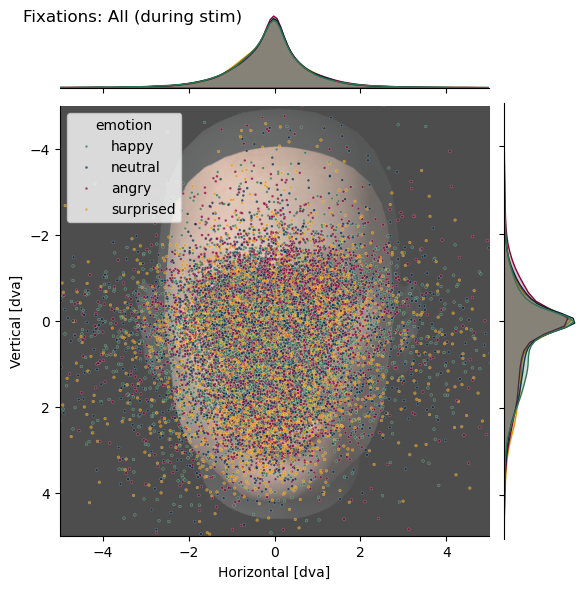

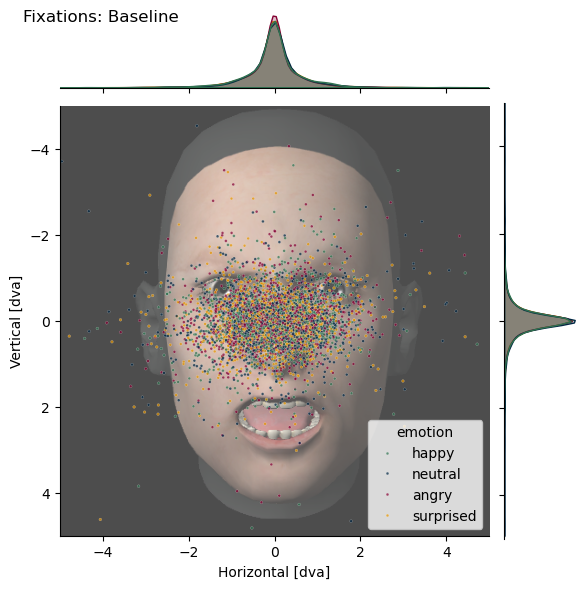

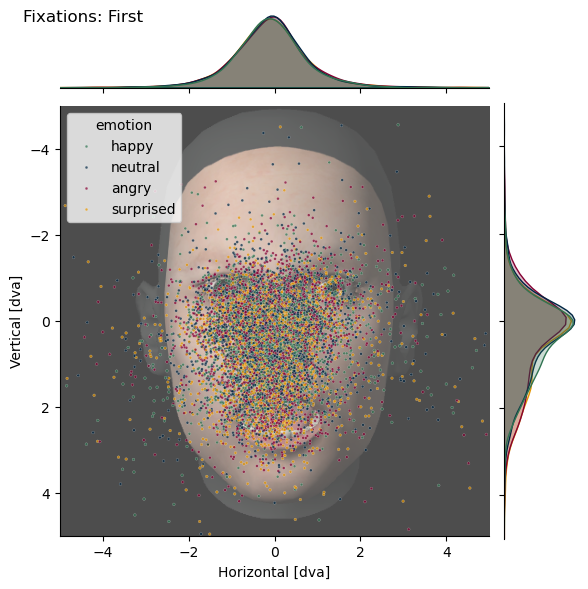

/u/fklotzsche/conda-envs/vr2fem/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


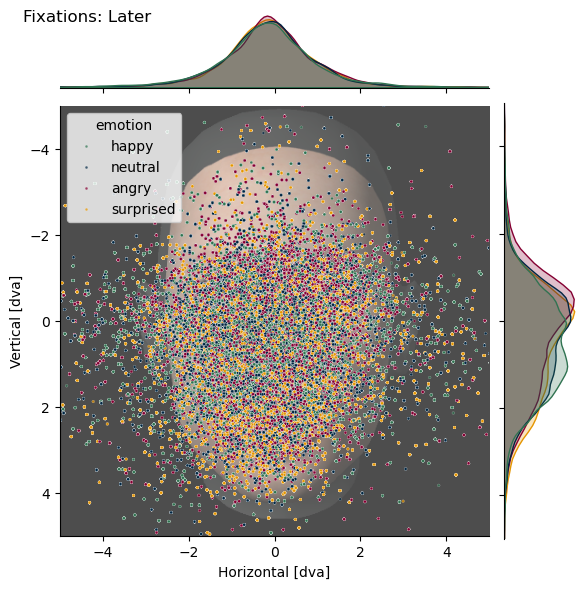

In [17]:
# Fixation diagnostics
fpath = Path(paths.FIGURES, "ET", "fixations")
fpath.mkdir(parents=True, exist_ok=True)

for df, title in zip((fixations_stim, fixations_baseline, fixations_first, fixations_later),
                      ("All (during stim)", "Baseline", "First", "Later"), strict=True):
  g = sns.jointplot(data=df, x="center_theta", y="center_phi", hue="emotion", palette=palette,
                    alpha=0.7, kind="scatter", s=4)
  g.fig.suptitle(f"Fixations: {title}", x=0.05, ha="left")
  g.fig.axes[0].set_ylim(-5, 5)
  g.fig.axes[0].set_xlim(-5, 5)
  g.fig.axes[0].set_xlabel("Horizontal [dva]")
  g.fig.axes[0].set_ylabel("Vertical [dva]")
  g.fig.axes[0].invert_yaxis()

  plot_faces.plot_image(av_name = "Woman_04", emotion = "angry", ax=g.fig.axes[0], invert=True, alpha=0.7)


This gives a useful first overview.  
1. Baselining did what it was supposed to do.
2. The first fixations are spread out in the eyes-to-mouth region. 
3. later fixations cover the entire face.
4. Anything "interesting" in contrasting emotion condition seems to happen along the vertical axis. 


# 4. Fixation heatmaps
Let us now plot heat maps separately for each facial expression and time window:


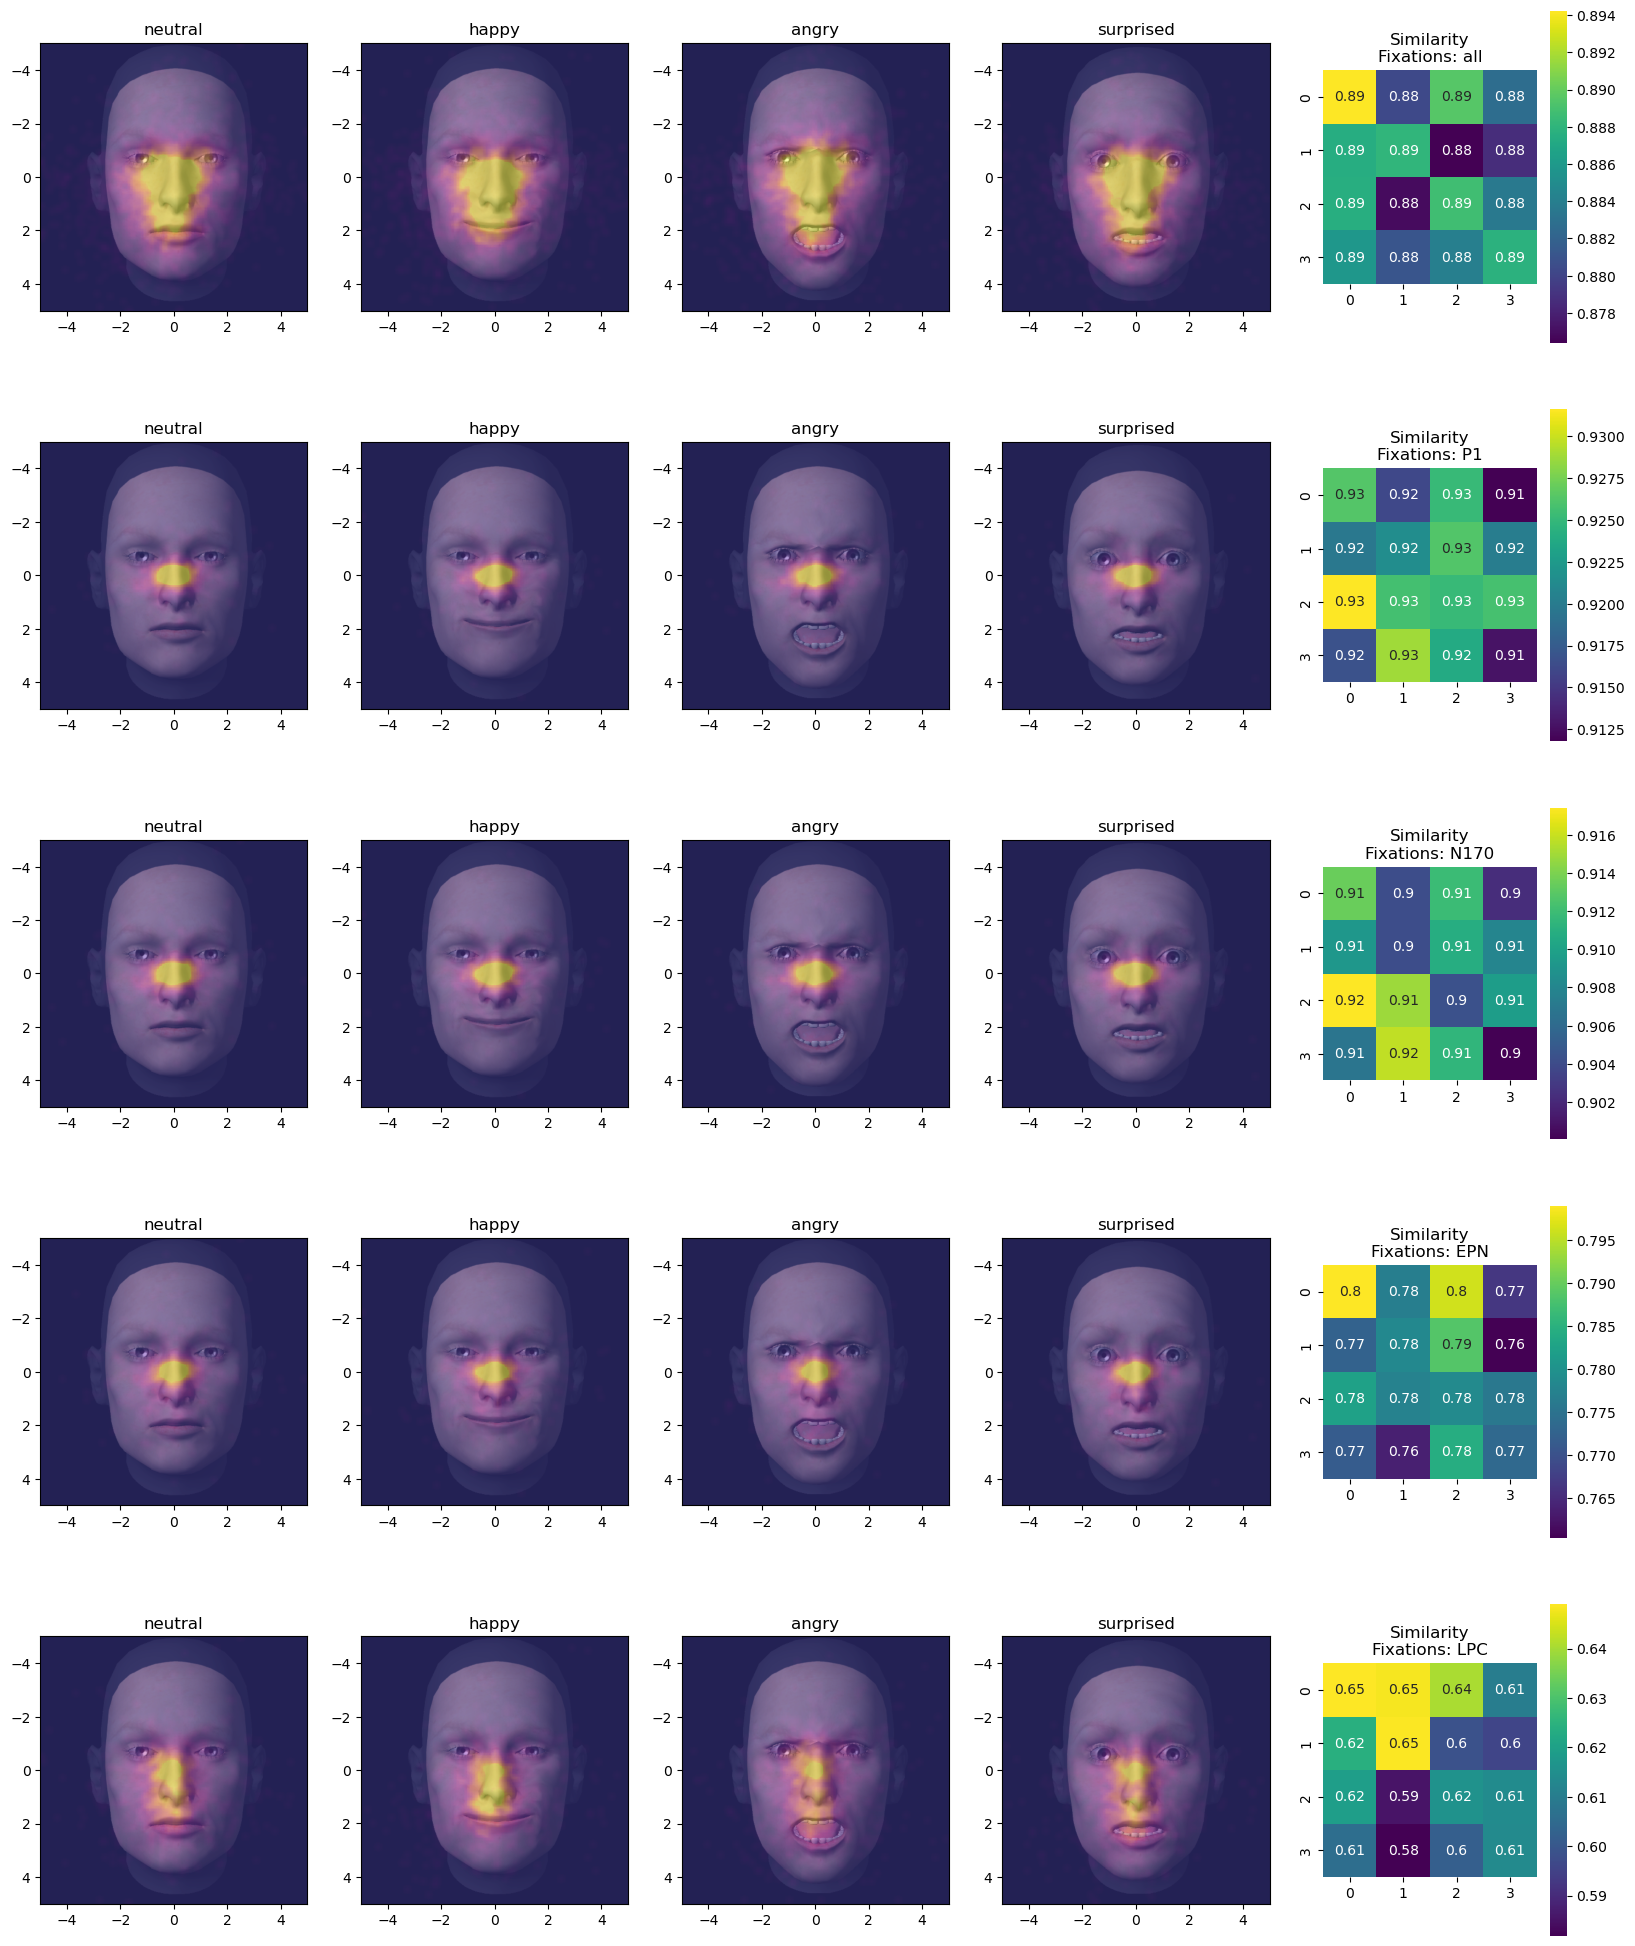

In [ ]:
save_fig = False

cond_dict = constants.COND_DICT
fix_data = [fixations_stim,
            fixations_p1,
            fixations_n170,
            fixations_epn,
            fixations_lpc,
           ]
titles = ["all",
          "P1",
          "N170",
          "EPN",
          "LPC"
         ]

viewconds = list(cond_dict["viewcond"].values())

for target in ["emotion"]: # , "avatar_id"]:
  values = cond_dict[target].values()

  fig, axs = plt.subplots(len(titles), len(values)+1, figsize=(5*len(values), 5*len(titles)))

  for i, f_df in enumerate(fix_data):
    smap_dict = {vc: {} for vc in viewconds}
    smap_dict_indiv = {vc: [] for vc in viewconds}
    for j, emo in enumerate(values):
      ax = axs[i, j]
      saliency_maps = {vc: [] for vc in viewconds}
      for sub_id in np.sort(f_df["sub_id"].unique()):
        for vc in viewconds:
          q_str = f"{target} == '{emo}' & sub_id == '{sub_id}' & viewcond == '{vc}'"
          smap = get_saliency_map(f_df, q_str)
          saliency_maps[vc].append(smap)

      saliency_map = {}
      saliency_map_indiv = {}
      for vc in viewconds:
        saliency_map[vc] = np.mean(np.array(saliency_maps[vc]), axis=0)
        saliency_map_indiv[vc] = saliency_maps[vc]

      if target == "emotion":
        plot_image("Woman_04", emo, ax, invert=True, alpha=0.8)
      elif target == "avatar_id":
        plot_image(emo, "angry", ax, invert=True, alpha=0.8)

      # plot avg across viewing conditions as heatmap
      saliency_map_avg = np.mean(np.array(list(saliency_map.values())), axis=0)
      #mask = saliency_map_avg < 0.05
      #saliency_map_avg = np.ma.masked_where(saliency_map_avg < 0.05, saliency_map_avg)
      ax.imshow(saliency_map_avg,
                cmap="plasma",
                origin="upper",
                extent=(-5, 5, 5, -5),
                vmin=0,
                vmax=0.2,
                alpha=0.4)
      ax.set_title(emo)

      for vc in viewconds:
        smap_dict[vc][emo] = saliency_map[vc].flatten()
        smap_dict[emo] = np.corrcoef(saliency_map["mono"].flatten(),
                                     saliency_map["stereo"].flatten())[0,1]
        corrs = []
        for sub_id in range(len(saliency_map_indiv[vc])):
          if len(smap_dict_indiv[vc]) < sub_id+1:
            smap_dict_indiv[vc].append({})
          smap_dict_indiv[vc][sub_id][emo] = saliency_map_indiv[vc][sub_id].flatten()
          corrs.append(np.corrcoef(saliency_map_indiv["mono"][sub_id].flatten(),
                                   saliency_map_indiv["stereo"][sub_id].flatten())[0,1])
        smap_dict[emo] = np.mean(corrs)
    # calc corr matrix between saliency maps
    smap_corr = {}
    for vc in viewconds:
      smap_df = pd.DataFrame(smap_dict[vc])
      smap_corr[vc] = smap_df.corr()
      corrmaps_indiv = []
      for sub_i in range(len(smap_dict_indiv[vc])):
        smap_df = pd.DataFrame(smap_dict_indiv[vc][sub_i])
        corrmaps_indiv.append(smap_df.corr())
      smap_corr[vc] = pd.DataFrame(np.mean(np.array(corrmaps_indiv), axis=0))
    smap_corr_plt = smap_corr[viewconds[0]].to_numpy()
    idx_upper_tri = np.triu_indices_from(smap_corr_plt, k=1)
    idx_lower_tri = np.tril_indices_from(smap_corr_plt, k=-1)
    idx_diag = np.diag_indices_from(smap_corr_plt)
    smap_corr_plt[idx_upper_tri] = smap_corr[viewconds[1]].to_numpy()[idx_upper_tri]
    smap_corr_plt[idx_diag] = [smap_dict[e] for e in cond_dict[target].values()]
    p = sns.heatmap(smap_corr_plt, annot=True, cmap="viridis", #vmin=0.9, vmax=1.0,
                    ax=axs[i, len(values)], square=True)
    axs[i, len(values)].set_title(f"Similarity\nFixations: {titles[i]}")

    # save as pdf
    fpath = Path(paths.FIGURES, "ET", "fixations")
    if save_fig:
      if not fpath.exists():
        fpath.mkdir(parents=True)
      plt.savefig(Path(fpath, f"fixations_saliencymaps_per_{target}_singlesub-corrs_plasma.pdf"), dpi=300,
      bbox_inches="tight", pad_inches=0)

fig.show()

fpath = Path(paths.FIGURES, "ET", "fixations")
if save_fig:
  if not fpath.exists():
    fpath.mkdir(parents=True)
  plt.savefig(Path(fpath, f"fixations_saliencymaps_per_emotion_singlesub-corrs_plasma.png"), dpi=300,
  bbox_inches="tight", pad_inches=0)

# 5. Fixation stats


In [14]:

fixations_p1_mean = (fixations_p1
                      .groupby(["sub_id", "emotion", "viewcond"], as_index=False)
                      .agg({"center_theta": "mean", "center_phi": "mean"})
                      .assign(time_window = "p1")
)

fixations_n170_mean = (fixations_n170
                      .groupby(["sub_id", "emotion", "viewcond"], as_index=False)
                      .agg({"center_theta": "mean", "center_phi": "mean"})
                      .assign(time_window = "n170")
)

fixations_epn_mean = (fixations_epn
                      .groupby(["sub_id", "emotion", "viewcond"], as_index=False)
                      .agg({"center_theta": "mean", "center_phi": "mean"})
                      .assign(time_window = "epn")
)

fixations_lpc_mean = (fixations_lpc
                      .groupby(["sub_id", "emotion", "viewcond"], as_index=False)
                      .agg({"center_theta": "mean", "center_phi": "mean"})
                      .assign(time_window = "lpc")
)

fixations_all_mean = pd.concat([fixations_p1_mean, fixations_n170_mean,
                                fixations_epn_mean, fixations_lpc_mean], ignore_index=True)

## 5.1 Horizontal position

<Axes: xlabel='time_window', ylabel='fix_pos_horizontal'>

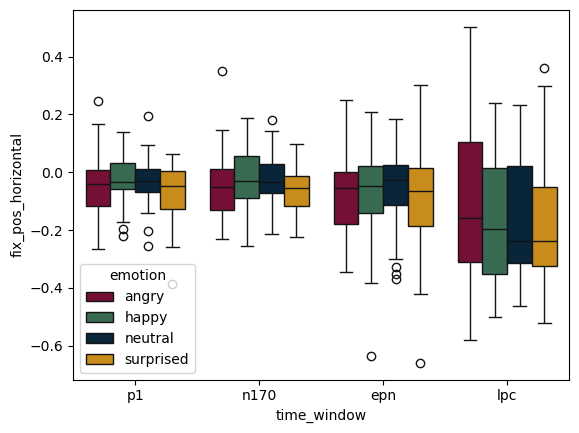

In [26]:
sns.boxplot(data=fixations_all_mean.rename(columns={"center_theta": "fix_pos_horizontal"}),
            x="time_window", 
            y="fix_pos_horizontal",
            hue="emotion",
            palette=palette)


## 5.2. Vertical position

<Axes: xlabel='time_window', ylabel='fix_pos_vertical'>

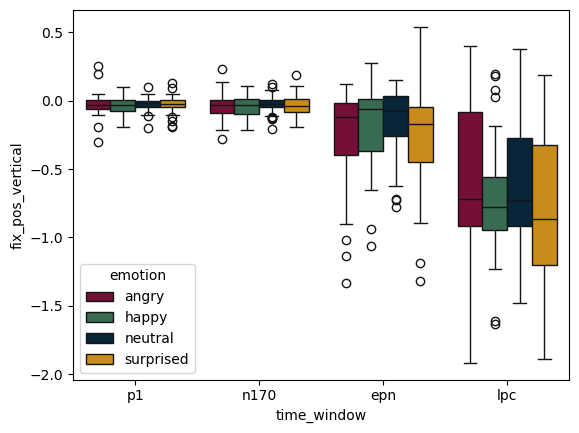

In [ ]:
sns.boxplot(data=fixations_all_mean.assign(fix_pos_vertical=lambda x: x["center_phi"] * -1),  # left handed coord system
                                           x="time_window",
                                           y="fix_pos_vertical",
                                           hue="emotion",
                                           palette=palette)

## 5.3 MANOVA: Fixation position ~ facial expression * viewing condition * time window

In [15]:

formula_emo_vc_tw = "center_theta + center_phi ~ C(emotion, Treatment('neutral')) * C(viewcond) * C(time_window, Treatment('p1'))"
model_emo_vc_tw = MANOVA.from_formula(formula_emo_vc_tw, data=fixations_all_mean, family=sm.families.Gaussian())
maov_res = model_emo_vc_tw.mv_test()
print(maov_res)


                                              Multivariate linear model
                                                                                                                     
--------------------------------------------------------------------------------------------------------------------------------
                   Intercept                   Value             Num DF             Den DF             F Value            Pr > F
--------------------------------------------------------------------------------------------------------------------------------
                      Wilks' lambda            0.9986            2.0000            511.0000             0.3601            0.6978
                     Pillai's trace            0.0014            2.0000            511.0000             0.3601            0.6978
             Hotelling-Lawley trace            0.0014            2.0000            511.0000             0.3601            0.6978
                Roy's greatest root 

In [37]:
PRINT_LATEX = False

if PRINT_LATEX:
  # print results for latex tables:
  for effect, tables in maov_res.results.items():
      print(f"Effect: {effect}")
      for test_name, table in tables.items():
          if isinstance(table, pd.DataFrame):
              print(table.to_latex(float_format="%.4f"))

### Post-hoc tests

In [17]:
# vertical gaze:
erp_windows = timings.ERP_WINDOWS
time_wins = list(erp_windows.keys())
time_wins = [tw.lower() for tw in time_wins]

run_rmanova_and_posthoc(df_aov=fixations_all_mean,
                        depvar="center_phi",
                        within=["emotion", "viewcond", "time_window"],
                        posthoc_dim="time_window",
                        posthoc_levels=time_wins,
                        subject="sub_id")

                           Anova
                             F Value Num DF  Den DF  Pr > F
-----------------------------------------------------------
emotion                       5.9374 3.0000  48.0000 0.0016
viewcond                      0.4546 1.0000  16.0000 0.5098
time_window                  26.0061 3.0000  48.0000 0.0000
emotion:viewcond              0.1975 3.0000  48.0000 0.8976
emotion:time_window           5.4732 9.0000 144.0000 0.0000
viewcond:time_window          0.8791 3.0000  48.0000 0.4586
emotion:viewcond:time_window  1.7718 9.0000 144.0000 0.0784

p1 vs n170: t = -0.79, p = 1.000
p1 vs epn: t = -2.72, p = 0.091
p1 vs lpc: t = -5.62, p = 0.000
n170 vs epn: t = -2.80, p = 0.077
n170 vs lpc: t = -5.73, p = 0.000
epn vs lpc: t = -5.38, p = 0.000


In [18]:
# horizontal gaze:
run_rmanova_and_posthoc(df_aov=fixations_all_mean,
                        depvar="center_theta",
                        within=["emotion", "viewcond", "time_window"],
                        posthoc_dim="time_window",
                        posthoc_levels=time_wins,
                        subject="sub_id")

                           Anova
                             F Value Num DF  Den DF  Pr > F
-----------------------------------------------------------
emotion                       1.4944 3.0000  48.0000 0.2280
viewcond                      1.2108 1.0000  16.0000 0.2874
time_window                   4.6208 3.0000  48.0000 0.0064
emotion:viewcond              0.1960 3.0000  48.0000 0.8986
emotion:time_window           1.9464 9.0000 144.0000 0.0499
viewcond:time_window          0.5791 3.0000  48.0000 0.6316
emotion:viewcond:time_window  0.4030 9.0000 144.0000 0.9318

p1 vs n170: t = 0.16, p = 1.000
p1 vs epn: t = 1.77, p = 0.578
p1 vs lpc: t = 2.31, p = 0.209
n170 vs epn: t = 1.99, p = 0.385
n170 vs lpc: t = 2.32, p = 0.202
epn vs lpc: t = 1.80, p = 0.541
